# Assignment-3

**Problem Statement:**
Build a CNN to classify different breeds of snakes, and visualize the effect of CNN layers.

**Task:**
1. Read train.csv and segregate the dataframe by 90:10 training-validation ratio
2. Display 16 random breeds of snakes from training set
3. Load the training image generator with rescale using Image Data Generator of
Tensorflow, apply any two following augmentation,
a. Rotation
b. Shifting
c. Horizontal Flip
d. Shearing
e. Zooming
4. Load the validation images using Image Data Generator but with only rescale option
5. Build the CNN model
6. Create a custom callback function for the model, set the condition if the model exceeds
70% or 80% accuracy then stop training the model
(Reference https://www.tensorflow.org/guide/keras/custom_callback )
7. Evaluate the validation set, compute F1 score and build confusion matrix
8. Visualize the effect of CNN layers on any image. Comment on the output layer images.
9. Display 10 random images with actual and predicted breed from validation set

In [1]:
!wget https://he-s3.s3.amazonaws.com/media/hackathon/hackerearth-deep-learning-challenge-snake-breed-detection/identify-the-snake-breed-5-66d9a9f5/8a95c26e1bab11eb.zip

--2022-08-16 07:41:39--  https://he-s3.s3.amazonaws.com/media/hackathon/hackerearth-deep-learning-challenge-snake-breed-detection/identify-the-snake-breed-5-66d9a9f5/8a95c26e1bab11eb.zip
Resolving he-s3.s3.amazonaws.com (he-s3.s3.amazonaws.com)... 52.219.32.152
Connecting to he-s3.s3.amazonaws.com (he-s3.s3.amazonaws.com)|52.219.32.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100929731 (96M) [application/zip]
Saving to: ‘8a95c26e1bab11eb.zip’

8a95c26e1bab11eb.zi 100%[===================>]  96.25M  12.7MB/s    in 9.2s    

2022-08-16 07:41:49 (10.5 MB/s) - ‘8a95c26e1bab11eb.zip’ saved [100929731/100929731]



In [2]:
!unzip /content/8a95c26e1bab11eb.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/b70a166bfe.jpg  
  inflating: dataset/train/d31875b68e.jpg  
  inflating: dataset/train/22c66793fb.jpg  
  inflating: dataset/train/a468b1390f.jpg  
  inflating: dataset/train/9e43d2cedc.jpg  
  inflating: dataset/train/2e0299e991.jpg  
  inflating: dataset/train/e0b85d8ff1.jpg  
  inflating: dataset/train/6a651ec04a.jpg  
  inflating: dataset/train/46c87716a5.jpg  
  inflating: dataset/train/8c40d4f073.jpg  
  inflating: dataset/train/96e4fb744c.jpg  
  inflating: dataset/train/794a698960.jpg  
  inflating: dataset/train/dad1934f35.jpg  
  inflating: dataset/train/a1c66a2b3c.jpg  
  inflating: dataset/train/b62484a8e4.jpg  
  inflating: dataset/train/09462814f1.jpg  
  inflating: dataset/train/97dbdb4dd0.jpg  
  inflating: dataset/train/3bd7f56164.jpg  
  inflating: dataset/train/a2576a2fa1.jpg  
  inflating: dataset/train/f462f66aa6.jpg  
  inflating: dataset/train/740e1a7fca.jpg  
  inflating: dataset/trai

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout
from keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, log_loss

from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model

import warnings
warnings.filterwarnings('ignore')

In [4]:
train = pd.read_csv("/content/dataset/train.csv")

In [5]:
train.head()

,image_id,breed
0,a8b3ad1dde,nerodia-erythrogaster
1,8b492b973d,pantherophis-vulpinus
2,929b99ea92,thamnophis-sirtalis
3,bbac7385e2,pantherophis-obsoletus
4,ef776b1488,agkistrodon-contortrix


In [6]:
train.columns = ['filename','class']
train.head()

,filename,class
0,a8b3ad1dde,nerodia-erythrogaster
1,8b492b973d,pantherophis-vulpinus
2,929b99ea92,thamnophis-sirtalis
3,bbac7385e2,pantherophis-obsoletus
4,ef776b1488,agkistrodon-contortrix


In [7]:
train['filename'] = '/content/dataset/train/' + train['filename'] + '.jpg'

In [8]:
train.head()

,filename,class
0,/content/dataset/train/a8b3ad1dde.jpg,nerodia-erythrogaster
1,/content/dataset/train/8b492b973d.jpg,pantherophis-vulpinus
2,/content/dataset/train/929b99ea92.jpg,thamnophis-sirtalis
3,/content/dataset/train/bbac7385e2.jpg,pantherophis-obsoletus
4,/content/dataset/train/ef776b1488.jpg,agkistrodon-contortrix


In [10]:
train['class'].value_counts()

thamnophis-sirtalis            509
storeria-dekayi                412
pantherophis-obsoletus         366
crotalus-atrox                 354
pituophis-catenifer            298
nerodia-sipedon                259
agkistrodon-contortrix         206
lampropeltis-triangulum        197
diadophis-punctatus            184
pantherophis-alleghaniensis    172
nerodia-erythrogaster          171
lampropeltis-californiae       166
opheodrys-aestivus             152
agkistrodon-piscivorus         147
crotalus-horridus              142
coluber-constrictor            129
heterodon-platirhinos          118
thamnophis-proximus            112
nerodia-rhombifer              104
thamnophis-radix               100
pantherophis-guttatus          100
haldea-striatula                98
pantherophis-spiloides          92
rhinocheilus-lecontei           91
storeria-occipitomaculata       87
masticophis-flagellum           83
crotalus-viridis                83
thamnophis-marcianus            82
crotalus-ruber      

In [11]:
unique_features = train['class'].unique()
len(unique_features)

35

In [12]:
sample = train.sample(16)
files = sample['filename'].tolist()
targets = sample['class'].tolist()

In [13]:
sample.head()

,filename,class
4062,/content/dataset/train/1f5b9a78ca.jpg,thamnophis-sirtalis
4086,/content/dataset/train/e283614809.jpg,pantherophis-alleghaniensis
2085,/content/dataset/train/78f89f13b4.jpg,nerodia-sipedon
4683,/content/dataset/train/adcb51819d.jpg,heterodon-platirhinos
5117,/content/dataset/train/bd35de4b4e.jpg,pantherophis-obsoletus


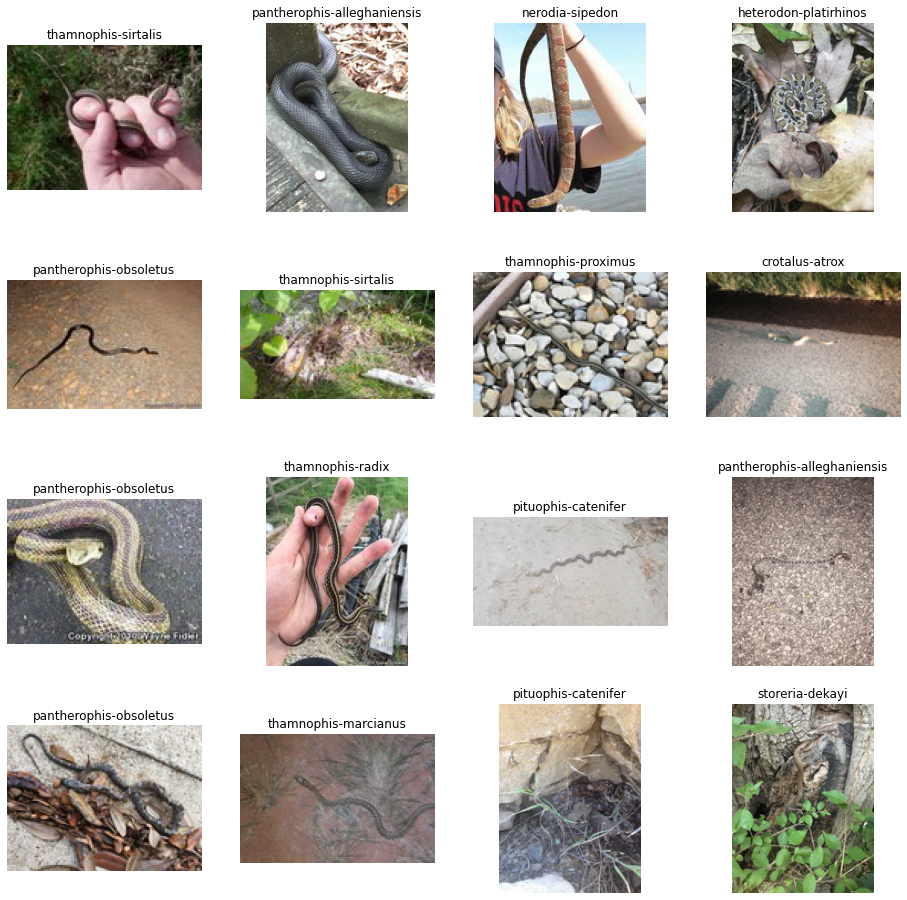

In [14]:
nrows = 4
ncols = 4
fig = plt.gcf()
fig.set_size_inches(nrows*4, ncols*4)

for i, (img_path,target) in enumerate(zip(files,targets)):
  sp = plt.subplot(nrows, ncols, i+1)
  sp.axis("off")
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.title(target)

plt.show()

In [15]:
temp_90 = train.sample(frac=0.9)
temp_10 = train.sample(frac=0.1)
x_train = temp_90.reset_index(drop = True)
x_val = temp_10.reset_index(drop=True)
x_train.shape, x_val.shape

((4957, 2), (551, 2))

In [16]:
x_train = train.sample(frac = 0.9)
x_val = train.drop(x_train.index)
x_train.shape, x_val.shape

((4957, 2), (551, 2))

In [17]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale=1/255,
      rotation_range=30,
#     width_shift_range=0.2, 
#     height_shift_range=0.2,
      shear_range=0.2,       
      zoom_range=0.3,       
      horizontal_flip=True
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe = x_train,
    directory = '/content/dataset/train',
    shuffle = True,
    target_size=(256,256),
    class_mode = 'categorical'
)

Found 4957 validated image filenames belonging to 35 classes.


In [18]:
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

val_generator = val_datagen.flow_from_dataframe(
    dataframe = x_val,
    directory = '/content/dataset/train',
    target_size=(256,256),
    shuffle =True,
    class_mode = 'categorical'
)

Found 551 validated image filenames belonging to 35 classes.


In [ ]:
tf.keras.backend.clear_session()

In [19]:

model = tf.keras.Sequential()

#Input Layer
model.add(InputLayer(input_shape=(256,256,3)))

#Conv and Max2D layers
'''model.add(Conv2D(filters = 64, kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))'''

model.add(Conv2D(filters = 32, kernel_size=(3,3),padding='valid',strides=(1,1),activation='relu')) 
model.add(MaxPooling2D(2,2))

model.add(Conv2D(filters = 16, kernel_size=(3,3),padding='valid',strides=(1,1),activation='relu')) 
model.add(MaxPooling2D(2,2))

model.add(Flatten())

#Hidden Layers
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))


model.add(Dropout(0.2))

#Output Layer
model.add(Dense(len(unique_features), activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)      4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 61504)             0         
                                                                 
 dense (Dense)               (None, 512)               3

In [20]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch,logs ={}):
        
        if(logs.get('accuracy')> 0.70): 
            self.model.stop_training = True
            
callback = CustomCallback()

In [22]:
history = model.fit(
      train_generator,
      epochs = 10,
      validation_data=val_generator,
      callbacks=[callback])

Epoch 1/10
155/155 [==============================] - 84s 459ms/step - loss: 3.4981 - accuracy: 0.0716 - val_loss: 3.4019 - val_accuracy: 0.0962
Epoch 2/10
155/155 [==============================] - 68s 440ms/step - loss: 3.4004 - accuracy: 0.0823 - val_loss: 3.3890 - val_accuracy: 0.0944
Epoch 3/10
155/155 [==============================] - 69s 446ms/step - loss: 3.3993 - accuracy: 0.0874 - val_loss: 3.3896 - val_accuracy: 0.0962
Epoch 4/10
155/155 [==============================] - 68s 439ms/step - loss: 3.3789 - accuracy: 0.0876 - val_loss: 3.3898 - val_accuracy: 0.0962
Epoch 5/10
155/155 [==============================] - 69s 444ms/step - loss: 3.3744 - accuracy: 0.0888 - val_loss: 3.3791 - val_accuracy: 0.0962
Epoch 6/10
155/155 [==============================] - 68s 438ms/step - loss: 3.3736 - accuracy: 0.0880 - val_loss: 3.3814 - val_accuracy: 0.0962
Epoch 7/10
155/155 [==============================] - 68s 441ms/step - loss: 3.3680 - accuracy: 0.0916 - val_loss: 3.3795 - val_ac

In [23]:
model.evaluate(val_generator)

18/18 [==============================] - 1s 55ms/step - loss: 3.3325 - accuracy: 0.1034


[3.332547187805176, 0.1034482792019844]

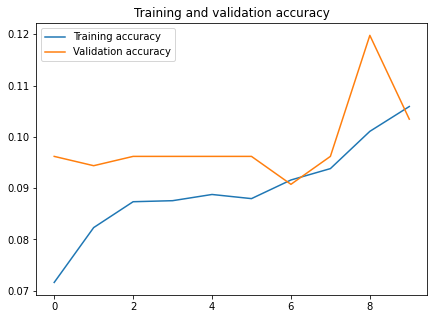

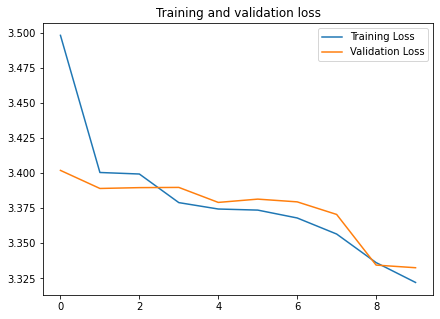

In [24]:
plt.figure(figsize=(7,5))

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(7,5))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [25]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report

prob = model.predict(val_generator)
pred = np.argmax(prob, axis=1)

In [26]:
print(confusion_matrix(val_generator.classes, pred))

[[ 0  0  0 ...  0  0  6]
 [ 0  0  0 ...  0  0  5]
 [ 0  0  0 ...  0  0  3]
 ...
 [ 0  0  0 ...  0  0  2]
 [ 0  0  0 ...  0  0  3]
 [ 0  0  0 ...  0  0 18]]


In [27]:
print("F-1 Score=", np.round(f1_score(val_generator.classes, pred, average='weighted'), 3))

F-1 Score= 0.033


# Visualizing the effect of CNN layers on a image

(256, 256, 3)
(1, 256, 256, 3)
(1, 254, 254, 32)
(1, 127, 127, 32)
(1, 125, 125, 16)
(1, 62, 62, 16)


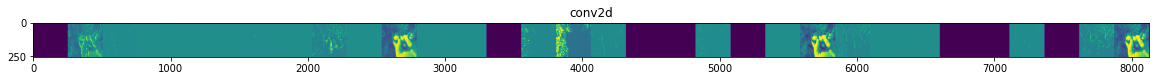

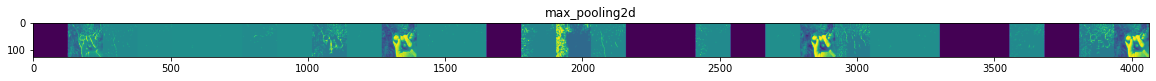

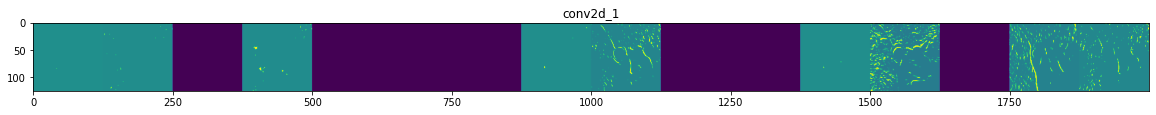

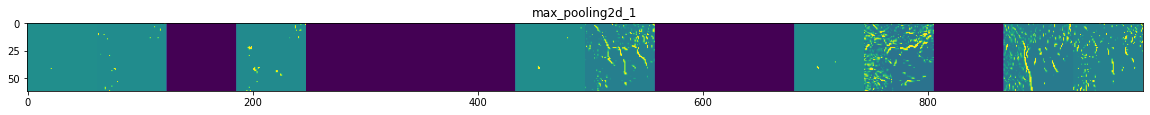

In [28]:
successive_outputs = [layer.output for layer in model.layers]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

img = tf.keras.preprocessing.image.load_img(files[0], target_size=(256, 256) )
x=tf.keras.preprocessing.image.img_to_array(img)
print(x.shape)
x=x.reshape ((1, ) + x.shape)
print (x.shape)
x/=255
successive_feature_maps = visualization_model.predict(x)
layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len (feature_map.shape) == 4:
    n_features = feature_map.shape[-1]
    print(feature_map.shape)
    size = feature_map.shape[1]
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      x= feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype ('uint8')
      display_grid[:, i*size : (i + 1) * size] = x
    scale =20. /n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

# Visualizing Predictions

In [29]:
labels = dict((v,k) for k,v in train_generator.class_indices.items())

In [30]:
pred_labels = [] 
actuals = []
pred = np.argmax(model.predict(val_generator), axis=1)
for i in range(551):
    pred_labels.append(labels[pred[i]])
    actuals.append(labels[val_generator.classes[i]])

In [31]:
test_df = pd.DataFrame(columns=['file', 'pred_labels', 'actuals'])
test_df['file'] = val_generator.filenames
test_df['pred_labels'] = pred_labels
test_df['actuals'] = actuals
test_df.head()

,file,pred_labels,actuals
0,/content/dataset/train/ef776b1488.jpg,thamnophis-sirtalis,agkistrodon-contortrix
1,/content/dataset/train/e6cef2b865.jpg,crotalus-atrox,haldea-striatula
2,/content/dataset/train/7add42e9aa.jpg,storeria-dekayi,pantherophis-obsoletus
3,/content/dataset/train/23b04b1237.jpg,storeria-dekayi,crotalus-ruber
4,/content/dataset/train/bff25ebb8c.jpg,storeria-dekayi,crotalus-viridis


In [32]:
sample = pd.DataFrame(test_df.sample(10))

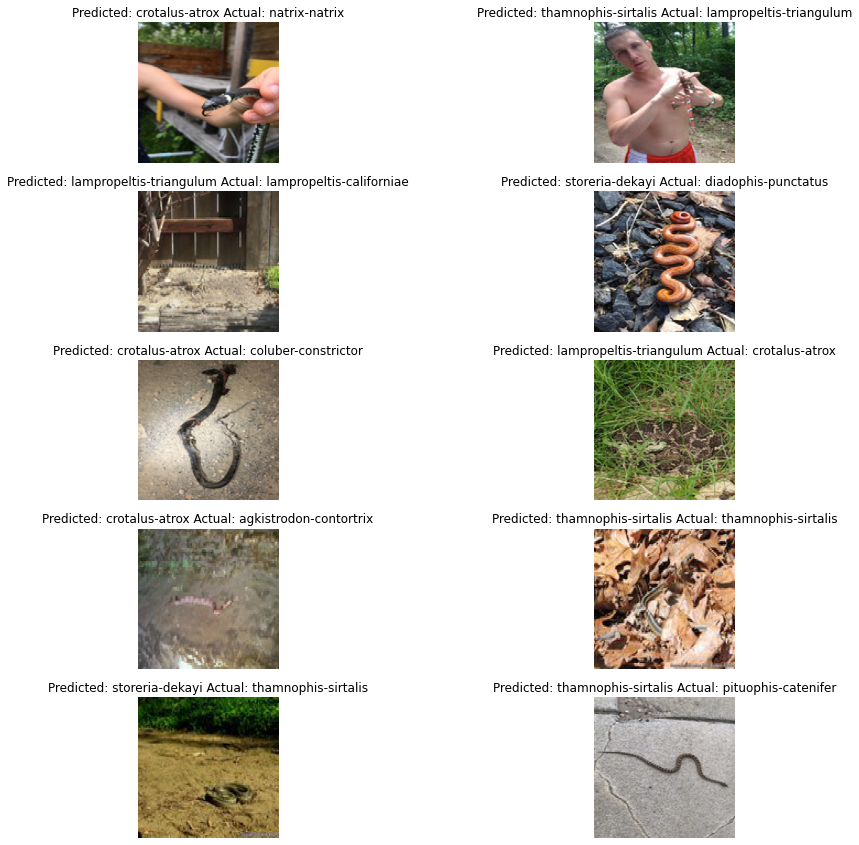

In [33]:
j=1
plt.figure(figsize=(15,15))
for i in sample.index:

  plt.subplot(5, 2, j)
  img = tf.keras.preprocessing.image.load_img(sample['file'][i], target_size = (256, 256))
  plt.imshow(img)
  plt.axis("off")
  plt.title("Predicted: " + test_df['pred_labels'][i] + " Actual: " + test_df['actuals'][i])
  j+=1